# **Practical Global Optimization for Multiview Geometry**

The original paper included a MATLAB code. We converted it to python.

There are 3 main functions in this code.
 -  1.Triangulation
 -  2.Triangulation Bound
 -  3.Triangulation Loop

Functions are divided into sub parts for better understanding. Full code is at the bottom of this notebook.

## **Setup and Initialization**

In [ ]:
import numpy as np
from numpy.linalg import norm, svd, pinv, inv
import cvxpy as cp
from typing import List, Tuple

## **null space function**

In [ ]:
def null_space(A, rtol=1e-5):
    u, s, vh = np.linalg.svd(A)
    rank = (s > rtol * s[0]).sum()
    return vh[rank:].T.copy()

## **pflat function**

In [ ]:
def pflat(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Normalization of projective points.
    Each column is considered to be a point in homogeneous coordinates.
    Normalize so that the last coordinate becomes 1.

    Args:
        x: matrix where each column is a point

    Returns:
        y: result after normalization (in homogeneous coordinates)
        alpha: depth
    """
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)

    a, n = x.shape
    alpha = x[a-1, :]
    y = x / alpha
    return y, alpha

null_space and pflat functions use to do a normalization for camera projection matrix

# **Triangulation function**

## Function Header and Input Initialization

Defining the inputs and checking for any missing values, setting defaults as necessary. The primary inputs are the set of image points u, projection matrices P, and algorithm

Parameters:

- u (np.ndarray): 2D projections in multiple images
- P (list): List of projection matrices for each image
- eps_perc (float): Allowed percentage gap for solution approximation
- max_error (float): Maximum pixel error allowed
- max_iter (int): Maximum number of iterations

### Python code part

In [ ]:
    def l2l2_triangulation(u, P, eps_perc=0.05, max_error=15, max_iter=200):

        print('\n\n******** Starting (L2,L2) Triangulation Algorithm ********\n\n')

        nbr_images = len(P)  # Get number of images (projections)
        eps_diff = 0.0

        eps_perc = 0.05  # Adjust percentage to match calculation needs

## Create Translation Camera Projection Matrix

In following we create transformed camera projection matrics from original projection matrics.

In [ ]:
    # Initialize transformed camera projection matrices
    Pt = []

    cc = np.zeros((3, nbr_images))   # Create 3 x nbr_images matrix with all elements zero

    # Tranform camera projection matrix pt[] from original given matrices p[]
    for i in range(nbr_images):
        Tim = np.eye(3)   # Create 3x3 identity matrix
        Tim[0:2, 2] = -u[:, i]    # Replace 3rd column of Tim with ith column of u
        Pt_i = np.matmul(Tim, P[i])   # Multiply chnged Tim with p[i] -- >original camera projection matrix of camera i and crete new transforned camera projection matrix pt[i]
        Pt.append(Pt_i)  # Create final pt which include all transformed camera projections
        ns = null_space(Pt_i)
        if ns.size == 0:
            print("Null space is empty for camera", i)
            return None, None
        temp,alpha = pflat(ns)  # Call pflat function for normalization
        cc[:, i] = temp[0:3, 0]  # Add temp matrix (it is a 3x1 column matrix) to the i th column of c matrix


## Compute an initial rotation matrix (RR) and translation vector (t0)

Here, we normalize the first camera’s matrix by aligning it based on the third row of its projection matrix, using singular value decomposition (SVD).

Uses the third row of the first transformed projection matrix to compute an initial rotation matrix (RR) and translation vector (t0).

In [ ]:
v = Pt[0][2, 0:3].T  # Take the third row of the first camera matrix
u_svd, s_svd, vt_svd = svd(v.reshape(-1, 1))  # Perform SVD to compute the rotation matrix
v = v.reshape(-1, 1)
sign_term = np.sign((u_svd[:, 0:1].T @ v)[0, 0])  # Determine sign for rotation matrix
RR = u_svd * sign_term  # Compute rotation matrix with correct orientation
t0 = cc[:, 0]  # Set initial translation vector


## Relative Positioning and Transformation Matrix

Using the normalized matrix, we calculate the relative positions of the cameras with respect to the first camera. We then build a transformation matrix T to scale and shift the points based on this reference, ensuring all projection matrices are scaled uniformly.

In [ ]:
tmp = RR.T @ (cc[:, 1:] - t0[:, np.newaxis])  # Compute relative positions of points
T = np.zeros((4, 4))  # Create a 4x4 transformation matrix
T[0:3, 0:3] = RR * np.std(tmp)  # Apply rotation and scaling
T[0:3, 3] = t0  # Add translation
T[3, 3] = 1  # Set homogeneous coordinate

## Scaling the Projection Matrices

We apply the transformation matrix T to each camera’s projection matrix and normalize them for consistent scaling. We also calculate an average scale factor im_scale to uniformly adjust the projection matrices for improved stability in further calculations.

In [ ]:
im_scale = 0
for i in range(nbr_images):
    Pt[i] = Pt[i] @ T  # Apply transformation to each projection matrix
    Pt[i] = Pt[i] / norm(Pt[i][2, :])  # Normalize by the third row
    im_scale += norm(Pt[i][0:2, :])  # Accumulate scaling factor
im_scale /= nbr_images  # Average the scale factor


## Main Iterative Optimization Loop

We now enter an iterative loop to refine the triangulation result. Each iteration checks if the current error v_opt can be reduced further. If the improvement is small enough (below the threshold), we stop iterating.

In [ ]:
iter_count = 1
while iter_count <= max_iter:
    vk = min(rect_lb)
    vk_index = np.argmin(rect_lb)
    v_diff = v_opt - vk
    perc = (v_opt - vk) / v_opt if v_opt != 0 else 0

    print(f'Iter: {iter_count} Residual: {v_opt * im_scale} Approximation gap: {perc * 100}% Regions: {len(rect)}')

    if v_diff < eps_diff or perc < eps_perc:
        break

## Splitting the Region and Updating Bounds

This part identifies the region with the largest error, which we will split to search more effectively. We find the dimension with the largest gap (pp), then split the interval by choosing a new boundary within this region.

In [ ]:
h = rect[vk_index]
gap = rect_yu[:, vk_index] - rect_yl[:, vk_index]
pp = np.argmax(gap)
tmp_yl = rect_yl[pp, vk_index]
tmp_yu = rect_yu[pp, vk_index]

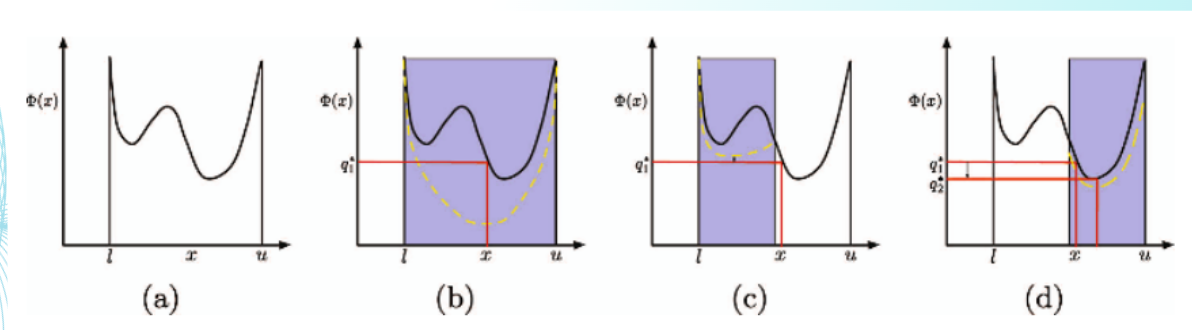

## Splitting

we pick a new boundary point within the region to reduce the largest gap and refine the search area more effectively.

In [ ]:
best_sol = h['lambda'][pp]
if (best_sol - tmp_yl) / (tmp_yu - tmp_yl) < alpha:
    new_border = tmp_yl + (tmp_yu - tmp_yl) * alpha
elif (tmp_yu - best_sol) / (tmp_yu - tmp_yl) < alpha:
    new_border = tmp_yu - (tmp_yu - tmp_yl) * alpha
else:
    new_border = best_sol


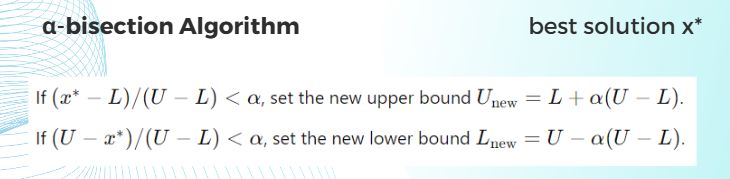

## Testing New Regions and Updating Solution

We run the triangulation algorithm in each newly defined region, seeing if the error in either region is lower than the current best solution (v_opt). If so, we update v_opt and store the new 3D point.

In [ ]:
h1 = l2_triangulation_loop(Pt, curr_yl1, curr_yu1, x_lb, x_ub, y_lb, y_ub)
h2 = l2_triangulation_loop(Pt, curr_yl2, curr_yu2, x_lb, x_ub, y_lb, y_ub)

## Final Transformation and Output

Finally, we apply a final transformation to get the 3D point back into the original coordinate system, adjusting it based on the earlier transformations. The function then returns the estimated 3D point and the number of iterations taken.

In [ ]:
U = pflat(T @ U[:, np.newaxis])[0]
U = U[0:3].flatten()

# Final triangulation function

In [ ]:
def l2l2_triangulation(u, P, eps_perc=0.05, max_error=15, max_iter=200):
    """
    Perform (L2,L2) triangulation to estimate a 3D point U from its 2D projections.

    Parameters:
        u (np.ndarray): 2D projections in multiple images
        P (list): List of projection matrices for each image
        eps_perc (float): Allowed percentage gap for solution approximation
        max_error (float): Maximum pixel error allowed
        max_iter (int): Maximum number of iterations

    Returns:
        tuple: (estimated 3D point, number of iterations)
    """
    print('\n\n******** Starting (L2,L2) Triangulation Algorithm ********\n\n')

    nbr_images = len(P)  # Get number of images (projections)

    eps_diff = 0.0
    eps_perc = 0.05  # Adjust percentage to match calculation needs


    # Initialize transformed camera projection matrices
    Pt = []

    cc = np.zeros((3, nbr_images))   # Create 3 x nbr_images matrix with all elements zero

    # Tranform camera projection matrix pt[] from original given matrices p[]
    for i in range(nbr_images):
        Tim = np.eye(3)   # Create 3x3 identity matrix
        Tim[0:2, 2] = -u[:, i]    # Replace 3rd column of Tim with ith column of u
        Pt_i = np.matmul(Tim, P[i])   # Multiply chnged Tim with p[i] -- >original camera projection matrix of camera i and crete new transforned camera projection matrix pt[i]
        Pt.append(Pt_i)  # Create final pt which include all transformed camera projections
        ns = null_space(Pt_i)
        if ns.size == 0:
            print("Null space is empty for camera", i)
            return None, None
        temp,alpha = pflat(ns)  # Call pflat function for normalization
        cc[:, i] = temp[0:3, 0]  # Add temp matrix (it is a 3x1 column matrix) to the i th column of c matrix


    v = Pt[0][2, 0:3].T  # Take the third row of the first camera matrix
    u_svd, s_svd, vt_svd = svd(v.reshape(-1, 1))  # Perform SVD to compute the rotation matrix
    v = v.reshape(-1, 1)
    sign_term = np.sign((u_svd[:, 0:1].T @ v)[0, 0])  # Determine sign for rotation matrix
    RR = u_svd * sign_term  # Compute rotation matrix with correct orientation
    t0 = cc[:, 0]  # Set initial translation vector


    # Compute relative positions
    tmp = RR.T @ (cc[:, 1:] - t0[:, np.newaxis])
    # Create transformation matrix
    T = np.zeros((4, 4))  # Create a 4x4 initial transformation matrix with zeros
    T[0:3, 0:3] = RR * np.std(tmp)  # Apply rotation and scaling
    T[0:3, 3] = t0  # Add translation
    T[3, 3] = 1  # Set homogeneous coordinate


    # Scale and normalize projection matrices
    im_scale = 0
    for i in range(nbr_images):
        Pt[i] = Pt[i] @ T
        Pt[i] = Pt[i] / norm(Pt[i][2, :])
        im_scale += norm(Pt[i][0:2, :])
    im_scale = im_scale / nbr_images


    # Scale projection matrices
    for i in range(nbr_images):
        Pt[i][0:2, :] = Pt[i][0:2, :] / im_scale

    P0 = Pt[0]

    # Set bounds
    thr = max_error / im_scale
    y_lb = 0.1
    y_ub = 10
    rect_yl, rect_yu = l2_triangulation_bound(Pt, thr, y_lb, y_ub)
    x_lb = 0
    x_ub = 0.1

    # Initialize triangulation
    hh = l2_triangulation_loop(Pt, rect_yl, rect_yu, x_lb, x_ub, y_lb, y_ub)
    if hh is None:
        print("Initial optimization failed.")
        return None, None
    v_opt = np.sum(hh['res'])
    U = np.array([1, *hh['y'][0:3]])

    # Store current bounds
    rect_lb = [hh['lowerbound']]
    rect = [hh]

    iter_count = 1
    while iter_count <= max_iter:
        # Find rectangle with smallest lower bound
        vk = min(rect_lb)
        vk_index = np.argmin(rect_lb)

        # Compute approximation gap
        v_diff = v_opt - vk
        perc = (v_opt - vk) / v_opt if v_opt != 0 else 0

        print(f'Iter: {iter_count} Residual: {v_opt * im_scale} Regions: {len(rect)}')

        if v_diff < eps_diff or perc < eps_perc:
            break

        # Split region with largest interval
        h = rect[vk_index]
        gap = rect_yu[:, vk_index] - rect_yl[:, vk_index]
        pp = np.argmax(gap)

        tmp_yl = rect_yl[pp, vk_index]
        tmp_yu = rect_yu[pp, vk_index]

        # Alpha bisection method
        best_sol = h['lambda'][pp]
        alpha = 0.1

        if (best_sol - tmp_yl) / (tmp_yu - tmp_yl) < alpha:
            new_border = tmp_yl + (tmp_yu - tmp_yl) * alpha
        elif (tmp_yu - best_sol) / (tmp_yu - tmp_yl) < alpha:
            new_border = tmp_yu - (tmp_yu - tmp_yl) * alpha
        else:
            new_border = best_sol

        # Update bounds for new regions
        curr_yl1 = rect_yl[:, vk_index].copy()
        curr_yu1 = rect_yu[:, vk_index].copy()
        curr_yl2 = curr_yl1.copy()
        curr_yu2 = curr_yu1.copy()
        curr_yu1[pp] = new_border
        curr_yl2[pp] = new_border

        # Update rectangles
        rect_yl = np.column_stack((rect_yl[:, :vk_index], curr_yl1[:, np.newaxis], curr_yl2[:, np.newaxis],
                                 rect_yl[:, vk_index + 1:]))
        rect_yu = np.column_stack((rect_yu[:, :vk_index], curr_yu1[:, np.newaxis], curr_yu2[:, np.newaxis],
                                 rect_yu[:, vk_index + 1:]))

        # Perform triangulation on new regions
        h1 = l2_triangulation_loop(Pt, curr_yl1, curr_yu1, x_lb, x_ub, y_lb, y_ub)
        h2 = l2_triangulation_loop(Pt, curr_yl2, curr_yu2, x_lb, x_ub, y_lb, y_ub)

        if h1 is None or h2 is None:
            print("Optimization failed during iteration.")
            break

        # Update solution if better one is found
        v_opt1 = np.sum(h1['res'])
        v_opt2 = np.sum(h2['res'])

        rect = rect[:vk_index] + [h1, h2] + rect[vk_index + 1:]
        rect_lb = rect_lb[:vk_index] + [h1['lowerbound'], h2['lowerbound']] + rect_lb[vk_index + 1:]

        if v_opt1 < v_opt:
            v_opt = v_opt1
            U = np.array([1, *h1['y'][0:3]])
        if v_opt2 < v_opt:
            v_opt = v_opt2
            U = np.array([1, *h2['y'][0:3]])

        # Remove useless rectangles
        remove_indices = [i for i in range(len(rect)) if rect_lb[i] > v_opt]
        for i in sorted(remove_indices, reverse=True):
            del rect[i]
            rect_yl = np.delete(rect_yl, i, axis=1)
            rect_yu = np.delete(rect_yu, i, axis=1)
            rect_lb.pop(i)

        iter_count += 1

    # Final transformation
    U = pflat(T @ U[:, np.newaxis])[0]
    U = U[0:3].flatten()

    print('******** Ending (L2,L2) Triangulation Algorithm ********\n\n')

    return U, iter_count

# **Branch and Bound Theory**

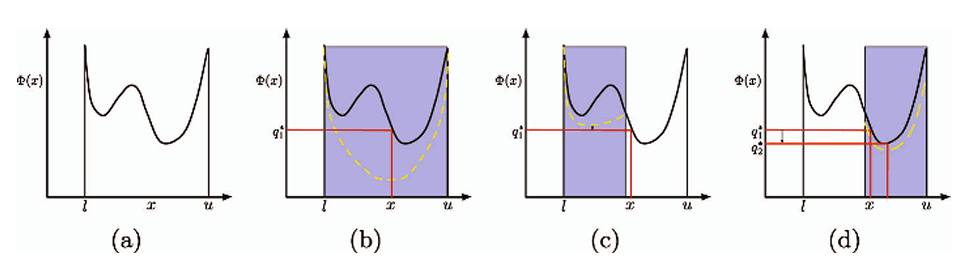

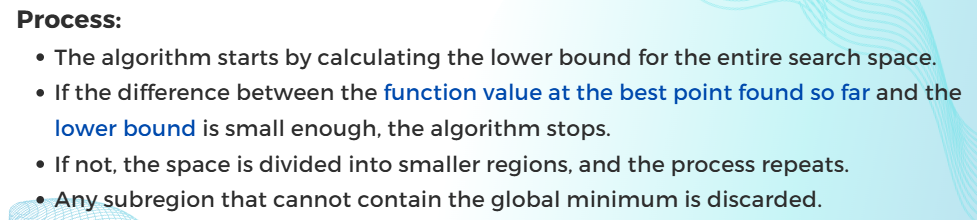

# **l2_triangulation_bound**

Goal: Find the tightest possible lower and upper bounds on the y-coordinate of a 3D point that,when projected into multiple camera views, results in reprojection residuals within specified thresholds.

Approach: Formulate optimization problems that minimize and maximize the y-coordinate (x[0]), subject to constraints derived from the camera projection matrices and reprojection residuals.

In [ ]:
def l2_triangulation_bound(Pt, thr, y_lb, y_ub):



- Parameters:
      Pt (list): List of camera projection matrices (each a 3x4 matrix)
      thr (float): Threshold for reprojection residuals
      y_lb (float): Lower bound on y-coordinate
      y_ub (float): Upper bound on y-coordinate

- Returns:
        tuple: (rect_yl, rect_yu) Lower and upper bounds for y-coordinate

**Initialization**

In [ ]:
nbr_images = len(Pt)   # Number of camera views
P0 = Pt[0]             # First camera matrix

# Number of bounds to compute
n = min(nbr_images - 1, 3)      #Limits the number of additional camera views considered to avoid excessive computation
rect_yl = np.zeros(n)
rect_yu = np.zeros(n)            #store the computed lower and upper bounds for the y-coordinate in each iteration.


**Main Loop Over Camera Views**

x: A CVXPY variable vector with size 2 + nbr_images,
- x[0]: y-coordinate of the 3D point (variable of interest).
- x[1]: z-coordinate of the 3D point.
- x[2]: Homogeneous coordinate w.
- x[3:]: Auxiliary variables for SOC constraints

In [ ]:
for ii in range(n):
    Ptmp = Pt[ii + 1]            # projection matrix of the next camera view to consider
    # Set up variables for cvxpy
    x = cp.Variable(2 + nbr_images)
    constraints = []


**Constraint for the First Camera View**

Ensures that the reprojection residual in the first camera view does not exceed the threshold

In [ ]:
constraints.append(cp.SOC(thr, P0[0:2, 1:4] @ x[0:3] - P0[0:2, 0]))


- P0[0:2, 1:4] @ x[0:3]: Projects the y, z, w coordinates into the image plane of the first camera.
- P0[0:2, 0]: Represents the component involving the x-coordinate (assumed known or fixed).
- cp.SOC(thr, ...): Creates a Second-Order Cone (SOC) constraint enforcing that the L2 norm of the residual is less than or equal to thr.

**Constraints for Additional Camera Views**

Adds reprojection residual constraints for each additional camera view.

In [ ]:
for cnt in range(nbr_images - 1):
    index_a = 3 + cnt  # Index for auxiliary variable a2, a3, ..., an
    Ptmp_i = Pt[cnt + 1]
    constraints.append(cp.SOC(x[index_a], Ptmp_i[0:2, 1:4] @ x[0:3] - Ptmp_i[0:2, 0]))


- index_a: Index for the auxiliary variable corresponding to the current camera view.
- x[index_a]: Auxiliary variable representing the threshold for the reprojection residual in the current camera view (optimized by the solver).
- Ptmp_i[0:2, 1:4] @ x[0:3] - Ptmp_i[0:2, 0]: Computes the reprojection residual for the current camera view.

**Bounds on the y-coordinate**

Ensures the y-coordinate stays within the specified bounds y_lb and y_ub

In [ ]:
constraints += [x[0] >= y_lb, x[0] <= y_ub]


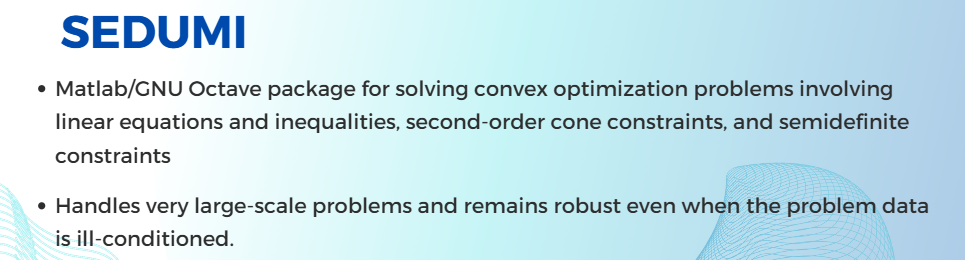

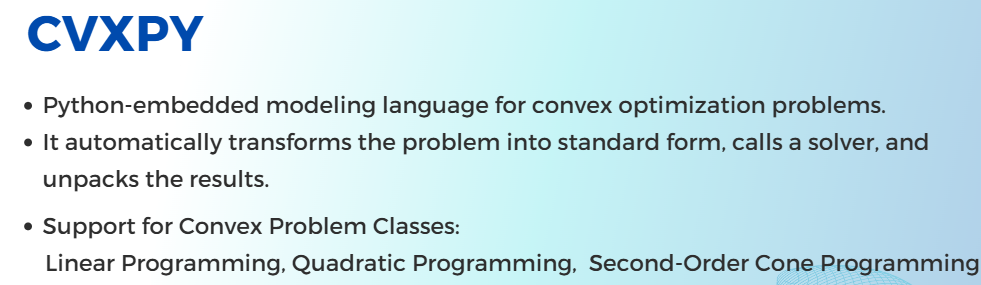

**Objective Functions**

- obj_min: Objective to minimize the y-coordinate (find the lower bound).
- obj_max: Objective to maximize the y-coordinate (find the upper bound).

In [ ]:
obj_min = cp.Minimize(x[0])
obj_max = cp.Maximize(x[0])


**Solving the Optimization Problems**

**1.Lower Bound Computation**

Defines an optimization problem to minimize x[0] (y-coordinate)

In [ ]:
prob_min = cp.Problem(obj_min, constraints)
try:
    prob_min.solve(solver=cp.SCS)
    rect_yl[ii] = prob_min.value
except:
    rect_yl[ii] = y_lb


- Attempts to solve the problem using the SCS solver.
- If successful, stores the optimal value in rect_yl[ii].
- If unsuccessful, defaults to y_lb

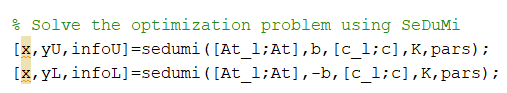

**2.Upper Bound Computation**

Defines an optimization problem to maximize x[0] (y-coordinate)

In [ ]:
prob_max = cp.Problem(obj_max, constraints)
try:
    prob_max.solve(solver=cp.SCS)
    rect_yu[ii] = prob_max.value
except:
    rect_yu[ii] = y_ub


- Attempts to solve the problem using the SCS solver.
- If successful, stores the optimal value in rect_yu[ii].
- If unsuccessful, defaults to y_ub.

**Returning the Results**

Returns the computed lower and upper bounds as column vectors

In [ ]:
return rect_yl.reshape(-1, 1), rect_yu.reshape(-1, 1)


**Full bound function**

In [ ]:
def l2_triangulation_bound(Pt, thr, y_lb, y_ub):
    """
    Parameters:
        Pt (list): List of camera projection matrices (each a 3x4 matrix)
        thr (float): Threshold for reprojection residuals
        y_lb (float): Lower bound on y-coordinate
        y_ub (float): Upper bound on y-coordinate

    Returns:
        tuple: (rect_yl, rect_yu) Lower and upper bounds for y-coordinate
    """
    nbr_images = len(Pt)  # Number of camera views
    P0 = Pt[0]  # First camera matrix

    # Number of bounds to compute (up to 3 views)
    n = min(nbr_images - 1, 3)   #avoid an excessively large number of bounds
    rect_yl = np.zeros(n)
    rect_yu = np.zeros(n)

    for ii in range(n):
        Ptmp = Pt[ii + 1]
        # Set up variables for cvxpy
        x = cp.Variable(2 + nbr_images)
        constraints = []

        # First residual (first camera view)
        constraints.append(cp.SOC(thr, P0[0:2, 1:4] @ x[0:3] - P0[0:2, 0]))

        # Second residual and remaining cameras
        for cnt in range(nbr_images - 1):
            index_a = 3 + cnt  # Index for auxiliary variable a2, a3, ..., an
            Ptmp_i = Pt[cnt + 1]
            constraints.append(cp.SOC(x[index_a], Ptmp_i[0:2, 1:4] @ x[0:3] - Ptmp_i[0:2, 0]))

        # Bounds on depth
        constraints += [x[0] >= y_lb, x[0] <= y_ub]

        # Objective functions to minimize and maximize x[0]
        obj_min = cp.Minimize(x[0])
        obj_max = cp.Maximize(x[0])

        # Solve for lower bound
        prob_min = cp.Problem(obj_min, constraints)
        try:
            prob_min.solve(solver=cp.SCS)
            rect_yl[ii] = prob_min.value
        except:
            rect_yl[ii] = y_lb

        # Solve for upper bound
        prob_max = cp.Problem(obj_max, constraints)
        try:
            prob_max.solve(solver=cp.SCS)
            rect_yu[ii] = prob_max.value
        except:
            rect_yu[ii] = y_ub

    return rect_yl.reshape(-1, 1), rect_yu.reshape(-1, 1)

# **l2_triangulation_loop**

Goal- find the 3D point X that minimizes the residuals between the observed 2D points and the projections of X onto each image plane, subject to certain constraints.

In [ ]:
def l2_triangulation_loop(Pt, rect_yL, rect_yU, xL, xU, yLB, yUB, verbose=False):


- parameters
      Pt: A list of transformed camera projection matrices after translating image points to the origin.
      rect_yL: lower bounds for the depth in each region
      rect_yU: upper bounds for the depth in each region
      xL, xU: Lower and upper bounds for the x-coordinate
      yLB, yUB: Global lower and upper bounds for the depth variables, providing overall limits beyond the regional bounds.
      verbose: A boolean flag to control the verbosity of the solver output.

- returns

      A dictionary containing the optimization results if successful, or None if the optimization fails.

 **Initialization**

In [ ]:
nbrimages = len(Pt)   #number of images (views) available
P0 = Pt[0]   #projection matrix for the first camera

vars = 3 + nbrimages + 3 * (nbrimages - 1)
index_z = [3 + nbrimages + i for i in range(0, 3 * (nbrimages - 1), 3)]

x = cp.Variable(vars)   #define the optimization variables
constraints = []
objective = 0


**First Camera Constraint**

In [ ]:
# First residual with relaxed cone constraint
constraints.append(cp.SOC(x[3], P0[0:2, 1:4] @ x[0:3] - P0[0:2, 0]))


- Constraint represents the residual between the observed 2D point in the first image and the projection of the estimated 3D point X onto the first image plane
- x[0:3]: The variables representing the estimated 3D point coordinates (X,Y,Z).
- P0[0:2, 1:4] @ x[0:3] - P0[0:2, 0]: Computes the difference between the projected point and the observed point in the image coordinates.

models the residual between the projected point and the observed point as a convex constraint, enabling the optimization to minimize this residual.

**Constraints and Objective for Remaining Cameras**

In [ ]:
for cnt in range(nbrimages - 1):
    index = index_z[cnt]  # Envelope variables start index
    indexa = 4 + cnt      # Auxiliary variable index

    Ptmp = Pt[cnt + 1]    # projection matrix for the current camera

    # Cone constraint with added slack
    slack = cp.Variable(1)
    constraints.append(cp.SOC(x[indexa] + slack, Ptmp[0:2, 1:4] @ x[0:3] - Ptmp[0:2, 0]))
    constraints.append(slack >= 0)  # Ensure non-negative slack
    objective += x[index] + 0.01 * slack  # Penalize slack slightly


- slack = cp.Variable(1): A slack variable introduced to relax the cone constraint slightly, ensuring feasibility even when the strict constraint cannot be met due to numerical issues or tight bounds.

**Depth Bounds with Flexibility**

In [ ]:
    # Depth bounds with some flexibility
    yL = max(rect_yL[cnt], yLB) if cnt < len(rect_yL) else yLB    # Ensures the lower bound is at least the global lower bound
    yU = min(rect_yU[cnt], yUB) if cnt < len(rect_yU) else yUB    # Ensures the upper bound does not exceed the global upper bound

    # Add depth constraints with soft boundaries
    depth = Ptmp[2, 1:4] @ x[0:3] + Ptmp[2, 0]
    depth_slack = cp.Variable(1)
    constraints += [
        depth >= yL - depth_slack,    # Allows the depth to be slightly less than the lower bound by an amount up to depth_slack
        depth <= yU + depth_slack,    # Allows the depth to be slightly more than the upper bound by an amount up to depth_slack
        depth_slack >= 0
    ]
    objective += 0.1 * depth_slack  # Penalize depth constraint violations


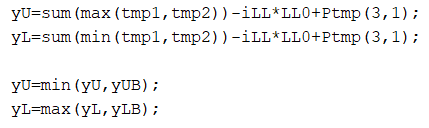

The penalty weight (0.1) is chosen to balance between allowing some flexibility and not excessively penalizing the slack.

**Convex Envelope Constraints with Relaxation**

In [ ]:
    # Convex envelope constraints with relaxation
    constraints.append(x[index] >= x[indexa])           # x[index]: The convex envelope variable zi for the current camera.
    constraints.append(x[index] >= -x[indexa])          # x[indexa]: The auxiliary variable ai irepresenting the residual norm.

These constraints are used to model the absolute value of the residual norms in a convex manner.

**Problem Definition and Solving**

In [ ]:
# Define the problem with modified objective
prob = cp.Problem(cp.Minimize(objective), constraints)

# Solve the problem with additional solver settings
prob.solve(
    solver=cp.SCS,     # SCS (Splitting Conic Solver) for solving the convex optimization problem
    verbose=verbose,
    max_iters=300,    # Maximum number of iterations for the solver to attempt convergence.
    eps=1e-3          # convergence tolerance (solver precision)
)

Minimize the sum of convex envelope variables zi (representing the residual norms) and the penalized slack variables.

**Handling Solver Results**

In [ ]:
if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:  # status returned by the solver
    U = np.concatenate(([1], x.value[0:3]))
    res = np.zeros(nbrimages)
    for ii in range(nbrimages):
        tmp, _ = pflat(Pt[ii] @ U)
        res[ii] = np.sum(tmp[0:2]**2)

    lowerbound = prob.value

    return {
        'res': res,
        'lowerbound': lowerbound,
        'y': x.value,
        'lambda': [Ptmp[2, :] @ U for Ptmp in Pt[1:]]
    }
else:
    return None


cvxpy status
- optimal: An optimal solution that meets all constraints.
- infeasible: No solution that satisfies all constraints
- unbounded: No finite optimal value exists

**Full loop code**

In [ ]:
def l2_triangulation_loop(Pt, rect_yL, rect_yU, xL, xU, yLB, yUB, verbose=False):
    nbrimages = len(Pt)
    P0 = Pt[0]

    vars = 3 + nbrimages + 3 * (nbrimages - 1)
    index_z = [3 + nbrimages + i for i in range(0, 3 * (nbrimages - 1), 3)]

    x = cp.Variable(vars)
    constraints = []
    objective = 0

    # First residual with relaxed cone constraint
    constraints.append(cp.SOC(x[3], P0[0:2, 1:4] @ x[0:3] - P0[0:2, 0]))

    # Process remaining residuals
    for cnt in range(nbrimages - 1):
        index = index_z[cnt]  # envelope variables start index
        indexa = 4 + cnt      # auxiliary variable index

        Ptmp = Pt[cnt + 1]    # camera cnt+1

        # Cone constraint with added slack
        slack = cp.Variable(1)
        constraints.append(cp.SOC(x[indexa] + slack, Ptmp[0:2, 1:4] @ x[0:3] - Ptmp[0:2, 0]))
        constraints.append(slack >= 0)  # Ensure non-negative slack
        objective += x[index] + 0.01 * slack  # Penalize slack slightly

        # Depth bounds with some flexibility
        yL = max(rect_yL[cnt], yLB) if cnt < len(rect_yL) else yLB
        yU = min(rect_yU[cnt], yUB) if cnt < len(rect_yU) else yUB

        # Add depth constraints with soft boundaries
        depth = Ptmp[2, 1:4] @ x[0:3] + Ptmp[2, 0]
        depth_slack = cp.Variable(1)
        constraints += [
            depth >= yL - depth_slack,
            depth <= yU + depth_slack,
            depth_slack >= 0
        ]
        objective += 0.1 * depth_slack  # Penalize depth constraint violations

        # Convex envelope constraints with relaxation
        constraints.append(x[index] >= x[indexa])
        constraints.append(x[index] >= -x[indexa])

    # Define the problem with modified objective
    prob = cp.Problem(cp.Minimize(objective), constraints)

    # Solve the problem with additional solver settings
    prob.solve(
        solver=cp.SCS,
        verbose=verbose,
        max_iters=300,   # Increase max iterations
        eps=1e-3          # Adjust solver precision
    )

    if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        U = np.concatenate(([1], x.value[0:3]))
        res = np.zeros(nbrimages)
        for ii in range(nbrimages):
            tmp, _ = pflat(Pt[ii] @ U)
            res[ii] = np.sum(tmp[0:2]**2)

        lowerbound = prob.value

        return {
            'res': res,
            'lowerbound': lowerbound,
            'y': x.value,
            'lambda': [Ptmp[2, :] @ U for Ptmp in Pt[1:]]
        }
    else:
        return None


In [ ]:
# Noisy observations
u = np.array([
    [-0.3487, -0.2224, -0.1640],
    [0.5565, 0.3505, 0.2561]
])

# Define projection matrices as a list of numpy arrays
P = []
P.append(np.array([
    [1, 0, 0, 0],
    [0, 2, 0, 0],
    [0, 0, 1, 2]
]))

P.append(np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 3]
]))

P.append(np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 4]
]))

# Ground truth without noise
U0 = np.array([-0.6084, 0.9552, -0.2676])

# Parameters
epsilon = 0.95
delta = 5
maxiter = 200

# Run triangulation
Ul2l2, iter_count = l2l2_triangulation(u, P, epsilon, delta, maxiter)

# Print results
print('Ground truth:')
print(U0)
print('\n(L2,L2) Estimate:')
print(Ul2l2)



******** Starting (L2,L2) Triangulation Algorithm ********


Iter: 1 Residual: 1.0484910312540434 Regions: 1
Iter: 2 Residual: 0.5841686518015861 Regions: 2
Iter: 3 Residual: 0.5841686518015861 Regions: 3
Iter: 4 Residual: 0.5841686518015861 Regions: 4
Iter: 5 Residual: 0.5841686518015861 Regions: 5
Iter: 6 Residual: 0.5841686518015861 Regions: 6
Iter: 7 Residual: 0.5841686518015861 Regions: 7
Iter: 8 Residual: 0.5841686518015861 Regions: 8
Iter: 9 Residual: 0.5841686518015861 Regions: 9
Iter: 10 Residual: 0.5841686518015861 Regions: 10
Iter: 11 Residual: 0.5841686518015861 Regions: 11
Iter: 12 Residual: 0.5841686518015861 Regions: 12
Iter: 13 Residual: 0.5841686518015861 Regions: 13
Iter: 14 Residual: 0.5841686518015861 Regions: 14
Iter: 15 Residual: 0.5841686518015861 Regions: 15
Iter: 16 Residual: 0.5841686518015861 Regions: 16
Iter: 17 Residual: 0.5841686518015861 Regions: 17
Iter: 18 Residual: 0.5841686518015861 Regions: 18
Iter: 19 Residual: 0.5841686518015861 Regions: 19
Iter:

# Full code

In [ ]:
import numpy as np
from numpy.linalg import norm, svd, pinv, inv
import cvxpy as cp
from typing import List, Tuple

def null_space(A, rtol=1e-5):
    u, s, vh = np.linalg.svd(A)
    rank = (s > rtol * s[0]).sum()
    return vh[rank:].T.copy()

def pflat(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Normalization of projective points.
    Each column is considered to be a point in homogeneous coordinates.
    Normalize so that the last coordinate becomes 1.

    Args:
        x: matrix where each column is a point

    Returns:
        y: result after normalization (in homogeneous coordinates)
        alpha: depth
    """
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)

    a, n = x.shape
    alpha = x[a-1, :]
    y = x / alpha
    return y, alpha

def l2l2_triangulation(u, P, eps_perc=0.05, max_error=15, max_iter=200):
    """
    Perform (L2,L2) triangulation to estimate a 3D point U from its 2D projections.

    Parameters:
        u (np.ndarray): 2D projections in multiple images
        P (list): List of projection matrices for each image
        eps_perc (float): Allowed percentage gap for solution approximation
        max_error (float): Maximum pixel error allowed
        max_iter (int): Maximum number of iterations

    Returns:
        tuple: (estimated 3D point, number of iterations)
    """
    print('\n\n******** Starting (L2,L2) Triangulation Algorithm ********\n\n')

    nbr_images = len(P)  # Get number of images (projections)

    eps_diff = 0.0
    eps_perc = 0.05  # Adjust percentage to match calculation needs


    # Initialize transformed camera projection matrices
    Pt = []

    cc = np.zeros((3, nbr_images))   # Create 3 x nbr_images matrix with all elements zero

    # Tranform camera projection matrix pt[] from original given matrices p[]
    for i in range(nbr_images):
        Tim = np.eye(3)   # Create 3x3 identity matrix
        Tim[0:2, 2] = -u[:, i]    # Replace 3rd column of Tim with ith column of u
        Pt_i = np.matmul(Tim, P[i])   # Multiply chnged Tim with p[i] -- >original camera projection matrix of camera i and crete new transforned camera projection matrix pt[i]
        Pt.append(Pt_i)  # Create final pt which include all transformed camera projections
        ns = null_space(Pt_i)
        if ns.size == 0:
            print("Null space is empty for camera", i)
            return None, None
        temp,alpha = pflat(ns)  # Call pflat function for normalization
        cc[:, i] = temp[0:3, 0]  # Add temp matrix (it is a 3x1 column matrix) to the i th column of c matrix


    v = Pt[0][2, 0:3].T  # Take the third row of the first camera matrix
    u_svd, s_svd, vt_svd = svd(v.reshape(-1, 1))  # Perform SVD to compute the rotation matrix
    v = v.reshape(-1, 1)
    sign_term = np.sign((u_svd[:, 0:1].T @ v)[0, 0])  # Determine sign for rotation matrix
    RR = u_svd * sign_term  # Compute rotation matrix with correct orientation
    t0 = cc[:, 0]  # Set initial translation vector


    # Compute relative positions
    tmp = RR.T @ (cc[:, 1:] - t0[:, np.newaxis])
    # Create transformation matrix
    T = np.zeros((4, 4))  # Create a 4x4 initial transformation matrix with zeros
    T[0:3, 0:3] = RR * np.std(tmp)  # Apply rotation and scaling
    T[0:3, 3] = t0  # Add translation
    T[3, 3] = 1  # Set homogeneous coordinate


    # Scale and normalize projection matrices
    im_scale = 0
    for i in range(nbr_images):
        Pt[i] = Pt[i] @ T
        Pt[i] = Pt[i] / norm(Pt[i][2, :])
        im_scale += norm(Pt[i][0:2, :])
    im_scale = im_scale / nbr_images


    # Scale projection matrices
    for i in range(nbr_images):
        Pt[i][0:2, :] = Pt[i][0:2, :] / im_scale

    P0 = Pt[0]

    # Set bounds
    thr = max_error / im_scale
    y_lb = 0.1
    y_ub = 10
    rect_yl, rect_yu = l2_triangulation_bound(Pt, thr, y_lb, y_ub)
    x_lb = 0
    x_ub = 0.1

    # Initialize triangulation
    hh = l2_triangulation_loop(Pt, rect_yl, rect_yu, x_lb, x_ub, y_lb, y_ub)
    if hh is None:
        print("Initial optimization failed.")
        return None, None
    v_opt = np.sum(hh['res'])
    U = np.array([1, *hh['y'][0:3]])

    # Store current bounds
    rect_lb = [hh['lowerbound']]
    rect = [hh]

    iter_count = 1
    while iter_count <= max_iter:
        # Find rectangle with smallest lower bound
        vk = min(rect_lb)
        vk_index = np.argmin(rect_lb)

        # Compute approximation gap
        v_diff = v_opt - vk
        perc = (v_opt - vk) / v_opt if v_opt != 0 else 0

        print(f'Iter: {iter_count} Residual: {v_opt * im_scale} Regions: {len(rect)}')

        if v_diff < eps_diff or perc < eps_perc:
            break

        # Split region with largest interval
        h = rect[vk_index]
        gap = rect_yu[:, vk_index] - rect_yl[:, vk_index]
        pp = np.argmax(gap)

        tmp_yl = rect_yl[pp, vk_index]
        tmp_yu = rect_yu[pp, vk_index]

        # Alpha bisection method
        best_sol = h['lambda'][pp]
        alpha = 0.1

        if (best_sol - tmp_yl) / (tmp_yu - tmp_yl) < alpha:
            new_border = tmp_yl + (tmp_yu - tmp_yl) * alpha
        elif (tmp_yu - best_sol) / (tmp_yu - tmp_yl) < alpha:
            new_border = tmp_yu - (tmp_yu - tmp_yl) * alpha
        else:
            new_border = best_sol

        # Update bounds for new regions
        curr_yl1 = rect_yl[:, vk_index].copy()
        curr_yu1 = rect_yu[:, vk_index].copy()
        curr_yl2 = curr_yl1.copy()
        curr_yu2 = curr_yu1.copy()
        curr_yu1[pp] = new_border
        curr_yl2[pp] = new_border

        # Update rectangles
        rect_yl = np.column_stack((rect_yl[:, :vk_index], curr_yl1[:, np.newaxis], curr_yl2[:, np.newaxis],
                                 rect_yl[:, vk_index + 1:]))
        rect_yu = np.column_stack((rect_yu[:, :vk_index], curr_yu1[:, np.newaxis], curr_yu2[:, np.newaxis],
                                 rect_yu[:, vk_index + 1:]))

        # Perform triangulation on new regions
        h1 = l2_triangulation_loop(Pt, curr_yl1, curr_yu1, x_lb, x_ub, y_lb, y_ub)
        h2 = l2_triangulation_loop(Pt, curr_yl2, curr_yu2, x_lb, x_ub, y_lb, y_ub)

        if h1 is None or h2 is None:
            print("Optimization failed during iteration.")
            break

        # Update solution if better one is found
        v_opt1 = np.sum(h1['res'])
        v_opt2 = np.sum(h2['res'])

        rect = rect[:vk_index] + [h1, h2] + rect[vk_index + 1:]
        rect_lb = rect_lb[:vk_index] + [h1['lowerbound'], h2['lowerbound']] + rect_lb[vk_index + 1:]

        if v_opt1 < v_opt:
            v_opt = v_opt1
            U = np.array([1, *h1['y'][0:3]])
        if v_opt2 < v_opt:
            v_opt = v_opt2
            U = np.array([1, *h2['y'][0:3]])

        # Remove useless rectangles
        remove_indices = [i for i in range(len(rect)) if rect_lb[i] > v_opt]
        for i in sorted(remove_indices, reverse=True):
            del rect[i]
            rect_yl = np.delete(rect_yl, i, axis=1)
            rect_yu = np.delete(rect_yu, i, axis=1)
            rect_lb.pop(i)

        iter_count += 1

    # Final transformation
    U = pflat(T @ U[:, np.newaxis])[0]
    U = U[0:3].flatten()

    print('******** Ending (L2,L2) Triangulation Algorithm ********\n\n')

    return U, iter_count

def l2_triangulation_bound(Pt, thr, y_lb, y_ub):
    """
    Parameters:
        Pt (list): List of camera projection matrices (each a 3x4 matrix)
        thr (float): Threshold for reprojection residuals
        y_lb (float): Lower bound on y-coordinate
        y_ub (float): Upper bound on y-coordinate

    Returns:
        tuple: (rect_yl, rect_yu) Lower and upper bounds for y-coordinate
    """
    nbr_images = len(Pt)  # Number of camera views
    P0 = Pt[0]  # First camera matrix

    # Number of bounds to compute (up to 3 views)
    n = min(nbr_images - 1, 3)   #avoid an excessively large number of bounds
    rect_yl = np.zeros(n)
    rect_yu = np.zeros(n)

    for ii in range(n):
        Ptmp = Pt[ii + 1]
        # Set up variables for cvxpy
        x = cp.Variable(2 + nbr_images)
        constraints = []

        # First residual (first camera view)
        constraints.append(cp.SOC(thr, P0[0:2, 1:4] @ x[0:3] - P0[0:2, 0]))

        # Second residual and remaining cameras
        for cnt in range(nbr_images - 1):
            index_a = 3 + cnt  # Index for auxiliary variable a2, a3, ..., an
            Ptmp_i = Pt[cnt + 1]
            constraints.append(cp.SOC(x[index_a], Ptmp_i[0:2, 1:4] @ x[0:3] - Ptmp_i[0:2, 0]))

        # Bounds on depth
        constraints += [x[0] >= y_lb, x[0] <= y_ub]

        # Objective functions to minimize and maximize x[0]
        obj_min = cp.Minimize(x[0])
        obj_max = cp.Maximize(x[0])

        # Solve for lower bound
        prob_min = cp.Problem(obj_min, constraints)
        try:
            prob_min.solve(solver=cp.SCS)
            rect_yl[ii] = prob_min.value
        except:
            rect_yl[ii] = y_lb

        # Solve for upper bound
        prob_max = cp.Problem(obj_max, constraints)
        try:
            prob_max.solve(solver=cp.SCS)
            rect_yu[ii] = prob_max.value
        except:
            rect_yu[ii] = y_ub

    return rect_yl.reshape(-1, 1), rect_yu.reshape(-1, 1)

def l2_triangulation_loop(Pt, rect_yL, rect_yU, xL, xU, yLB, yUB, verbose=False):
    nbrimages = len(Pt)
    P0 = Pt[0]

    vars = 3 + nbrimages + 3 * (nbrimages - 1)
    index_z = [3 + nbrimages + i for i in range(0, 3 * (nbrimages - 1), 3)]

    x = cp.Variable(vars)
    constraints = []
    objective = 0

    # First residual with relaxed cone constraint
    constraints.append(cp.SOC(x[3], P0[0:2, 1:4] @ x[0:3] - P0[0:2, 0]))

    # Process remaining residuals
    for cnt in range(nbrimages - 1):
        index = index_z[cnt]  # envelope variables start index
        indexa = 4 + cnt      # auxiliary variable index

        Ptmp = Pt[cnt + 1]    # camera cnt+1

        # Cone constraint with added slack
        slack = cp.Variable(1)
        constraints.append(cp.SOC(x[indexa] + slack, Ptmp[0:2, 1:4] @ x[0:3] - Ptmp[0:2, 0]))
        constraints.append(slack >= 0)  # Ensure non-negative slack
        objective += x[index] + 0.01 * slack  # Penalize slack slightly

        # Depth bounds with some flexibility
        yL = max(rect_yL[cnt], yLB) if cnt < len(rect_yL) else yLB
        yU = min(rect_yU[cnt], yUB) if cnt < len(rect_yU) else yUB

        # Add depth constraints with soft boundaries
        depth = Ptmp[2, 1:4] @ x[0:3] + Ptmp[2, 0]
        depth_slack = cp.Variable(1)
        constraints += [
            depth >= yL - depth_slack,
            depth <= yU + depth_slack,
            depth_slack >= 0
        ]
        objective += 0.1 * depth_slack  # Penalize depth constraint violations

        # Convex envelope constraints with relaxation
        constraints.append(x[index] >= x[indexa])
        constraints.append(x[index] >= -x[indexa])

    # Define the problem with modified objective
    prob = cp.Problem(cp.Minimize(objective), constraints)

    # Solve the problem with additional solver settings
    prob.solve(
        solver=cp.SCS,
        verbose=verbose,
        max_iters=300,   # Increase max iterations
        eps=1e-3          # Adjust solver precision
    )

    if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        U = np.concatenate(([1], x.value[0:3]))
        res = np.zeros(nbrimages)
        for ii in range(nbrimages):
            tmp, _ = pflat(Pt[ii] @ U)
            res[ii] = np.sum(tmp[0:2]**2)

        lowerbound = prob.value

        return {
            'res': res,
            'lowerbound': lowerbound,
            'y': x.value,
            'lambda': [Ptmp[2, :] @ U for Ptmp in Pt[1:]]
        }
    else:
        return None

# Noisy observations
u = np.array([
    [-0.3487, -0.2224, -0.1640],
    [0.5565, 0.3505, 0.2561]
])

# Define projection matrices as a list of numpy arrays
P = []
P.append(np.array([
    [1, 0, 0, 0],
    [0, 2, 0, 0],
    [0, 0, 1, 2]
]))

P.append(np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 3]
]))

P.append(np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 4]
]))

# Ground truth without noise
U0 = np.array([-0.6084, 0.9552, -0.2676])

# Parameters
epsilon = 0.95
delta = 5
maxiter = 200

# Run triangulation
Ul2l2, iter_count = l2l2_triangulation(u, P, epsilon, delta, maxiter)

# Print results
print('Ground truth:')
print(U0)
print('\n(L2,L2) Estimate:')
print(Ul2l2)



******** Starting (L2,L2) Triangulation Algorithm ********


Iter: 1 Residual: 1.0484910312540434 Regions: 1
Iter: 2 Residual: 0.5841686518015861 Regions: 2
Iter: 3 Residual: 0.5841686518015861 Regions: 3
Iter: 4 Residual: 0.5841686518015861 Regions: 4
Iter: 5 Residual: 0.5841686518015861 Regions: 5
Iter: 6 Residual: 0.5841686518015861 Regions: 6
Iter: 7 Residual: 0.5841686518015861 Regions: 7
Iter: 8 Residual: 0.5841686518015861 Regions: 8
Iter: 9 Residual: 0.5841686518015861 Regions: 9
Iter: 10 Residual: 0.5841686518015861 Regions: 10
Iter: 11 Residual: 0.5841686518015861 Regions: 11
Iter: 12 Residual: 0.5841686518015861 Regions: 12
Iter: 13 Residual: 0.5841686518015861 Regions: 13
Iter: 14 Residual: 0.5841686518015861 Regions: 14
Iter: 15 Residual: 0.5841686518015861 Regions: 15
Iter: 16 Residual: 0.5841686518015861 Regions: 16
Iter: 17 Residual: 0.5841686518015861 Regions: 17
Iter: 18 Residual: 0.5841686518015861 Regions: 18
Iter: 19 Residual: 0.5841686518015861 Regions: 19
Iter: